In [ ]:
import torch
from torch.autograd import Variable
from collections import namedtuple
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import os
import sys
import random
from PIL import Image
import glob
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import cv2


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


def gram_matrix(y):
    """ Returns the gram matrix of y (used to compute style loss) """
    (b, c, h, w) = y.size()
    features = y.view(b, c, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (c * h * w)
    return gram


mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def train_transform(image_size):
    """ Transforms for training images """
    transform = transforms.Compose(
        [
            transforms.Resize((int(image_size * 1.15),int(image_size * 1.15))),
            transforms.RandomCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    )
    return transform


def style_transform(image_size=None):
    """ Transforms for style image """
    resize = [transforms.Resize((image_size,image_size))] if image_size else []
    transform = transforms.Compose(resize + [transforms.ToTensor(), transforms.Normalize(mean, std)])
    return transform

def test_transform(image_size=None):
    """ Transforms for test image """
    resize = [transforms.Resize(image_size)] if image_size else []
    transform = transforms.Compose(resize + [transforms.ToTensor(), transforms.Normalize(mean, std)])
    return transform

def denormalize(tensors):
    """ Denormalizes image tensors using mean and std """
    for c in range(3):
        tensors[:, c].mul_(std[c]).add_(mean[c])
    return tensors


def deprocess(image_tensor):
    """ Denormalizes and rescales image tensor """
    image_tensor = denormalize(image_tensor)[0]
    image_tensor *= 255
    image_np = torch.clamp(image_tensor, 0, 255).cpu().numpy().astype(np.uint8)
    image_np = image_np.transpose(1, 2, 0)
    return image_np

def test_image(image_path,checkpoint_model,save_path, save_name):
    os.makedirs(os.path.join(save_path,"results"), exist_ok=True)

    transform = test_transform()

    # Define model and load model checkpoint
    transformer = TransformerNet().to(device)
    transformer.load_state_dict(torch.load(checkpoint_model))
    transformer.eval()

    # Prepare input
    image_tensor = Variable(transform(Image.open(image_path))).to(device)
    image_tensor = image_tensor.unsqueeze(0)

    # Stylize image
    with torch.no_grad():
        stylized_image = denormalize(transformer(image_tensor)).cpu()
    # Save image
    fn = checkpoint_model.split('/')[-1].split('.')[0]
    save_image(stylized_image, os.path.join(save_path,f"results/{fn}-{save_name}-output.jpg"))
    print("Image Saved!")
    plt.imshow(cv2.cvtColor(cv2.imread(os.path.join(save_path,f"results/{fn}-{save_name}-output.jpg")), cv2.COLOR_BGR2RGB))

In [ ]:
! ls ./styles

kandinsky.jpg  mone2_.jpg


In [ ]:
! mkdir ./drive/MyDrive/dls_project/	
! mkdir ./drive/MyDrive/dls_project/checkpoints	

mkdir: cannot create directory ‘./drive/MyDrive/dls_project/’: File exists
mkdir: cannot create directory ‘./drive/MyDrive/dls_project/checkpoints’: File exists


In [ ]:
GDRIVE_PATH = "./drive/MyDrive/dls_project/"

### Обучение Transfer Style моделей.

In [ ]:
seed_everything(42)
DEVICE = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DEVICE

device(type='cuda')

In [ ]:
# скачиваем датасет COCO

if not os.path.exists("./dataset") or len(os.listdir("dataset")) == 0:
    if not os.path.exists("test2017.zip"):
        print("Downloading zip dataset...")
        code = os.system("wget http://images.cocodataset.org/zips/test2017.zip")
        if code != 0:
            raise RuntimeError("Ошибка при загрузке.")
    os.makedirs("./dataset", exist_ok=True)
    os.system("unzip -q ./test2017.zip -d './dataset'")

In [ ]:
class VGG16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(VGG16, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        
        
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ["relu1_2", "relu2_2", "relu3_3", "relu4_3"])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out


class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        self.model = nn.Sequential(
            ConvBlock(3, 32, kernel_size=9, stride=1),
            ConvBlock(32, 64, kernel_size=3, stride=2),
            ConvBlock(64, 128, kernel_size=3, stride=2),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ConvBlock(128, 64, kernel_size=3, upsample=True),
            ConvBlock(64, 32, kernel_size=3, upsample=True),
            ConvBlock(32, 3, kernel_size=9, stride=1, normalize=False, relu=False),
        )

    def forward(self, x):
        return self.model(x)


class ResidualBlock(torch.nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=True),
            ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=False),
        )

    def forward(self, x):
        return self.block(x) + x


class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, upsample=False, normalize=True, relu=True):
        super(ConvBlock, self).__init__()
        self.upsample = upsample
        self.block = nn.Sequential(
            nn.ReflectionPad2d(kernel_size // 2), nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        )
        self.norm = nn.InstanceNorm2d(out_channels, affine=True) if normalize else None
        self.relu = relu

    def forward(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2)
        x = self.block(x)
        if self.norm is not None:
            x = self.norm(x)
        if self.relu:
            x = F.relu(x)
        return x

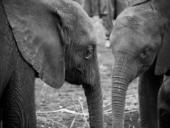

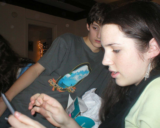

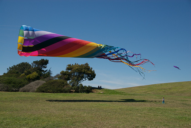

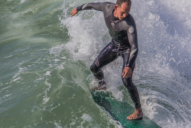

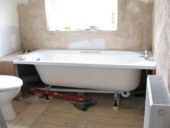

In [ ]:
DATASET = datasets.ImageFolder("./dataset", transform=transforms.Resize(128))

np.random.seed(127)
for random_image_index in np.random.randint(0, len(DATASET) - 1, size=5):
    display(DATASET[random_image_index][0])

In [ ]:
def fast_trainer(style_image,    
                 style_name,     
                 dataset_path,   
                 image_size=256,
                 style_size=448,
                 batch_size = 8,
                 lr = 1e-5,
                 epochs = 1,
                 # checkpoint_model = None,
                 checkpoint_interval=200,
                 sample_interval=200,
                 lambda_style=10e10,
                 lambda_content=10e5,):
    
    os.makedirs(f"./images/outputs/{style_name}-training", exist_ok=True)
    os.makedirs(f"./checkpoints", exist_ok=True)


    """ Create dataloader for the training data """
    train_dataset = datasets.ImageFolder(dataset_path, train_transform(image_size))
    dataloader = DataLoader(train_dataset, batch_size=batch_size)

    """ Define networks """
    transformer = TransformerNet().to(device)
    vgg = VGG16().to(device)

    # """ Load checkpoint model if specified """
    # if checkpoint_model:
    #     transformer.load_state_dict(torch.load(checkpoint_model))

    """ Define optimizer and loss """
    optimizer = Adam(transformer.parameters(), lr)
    l2_loss = torch.nn.MSELoss().to(device)

    """ Load style image """
    style = style_transform(style_size)(Image.open(style_image))
    style = style.repeat(batch_size, 1, 1, 1).to(device)

    """ Extract style features """
    features_style = vgg(style)
    gram_style = [gram_matrix(y) for y in features_style]

    """ Sample 8 images for visual evaluation of the model """
    image_samples = []
    for path in random.sample(glob.glob(f"{dataset_path}/*/*.jpg"), 8):
        image_samples += [style_transform(image_size)(Image.open(path))]
    image_samples = torch.stack(image_samples)

    def save_sample(batches_done):
        """ Evaluates the model and saves image samples """
        transformer.eval()
        with torch.no_grad():
            output = transformer(image_samples.to(device))
        image_grid = denormalize(torch.cat((image_samples.cpu(), output.cpu()), 2))
        save_image(image_grid, f"./images/outputs/{style_name}-training/{batches_done}.jpg", nrow=4)
        transformer.train()
    
    
    train_metrics = {"content": [], "style": [], "total": []}
    for epoch in range(epochs):
        epoch_metrics = {"content": [], "style": [], "total": []}
        for batch_i, (images, _) in enumerate(dataloader):
            optimizer.zero_grad()

            images_original = images.to(device)
            images_transformed = transformer(images_original)

            # Extract features
            features_original = vgg(images_original)
            features_transformed = vgg(images_transformed)

            # Compute content loss as MSE between features
            content_loss = lambda_content * l2_loss(features_transformed[1], features_original[1])

            # Compute style loss as MSE between gram matrices
            style_loss = 0
            for ft_y, gm_s in zip(features_transformed, gram_style):
                gm_y = gram_matrix(ft_y)
                style_loss += l2_loss(gm_y, gm_s[: images.size(0), :, :])
            style_loss *= lambda_style

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            epoch_metrics["content"] += [content_loss.item()]
            epoch_metrics["style"] += [style_loss.item()]
            epoch_metrics["total"] += [total_loss.item()]
            
            train_metrics["content"] += [content_loss.item()]
            train_metrics["style"] += [style_loss.item()]
            train_metrics["total"] += [total_loss.item()]

            if batch_i % 1000 == 0:
              print(
                  "\r[Epoch %d/%d] [Batch %d/%d] [Content: %.2f (%.2f) Style: %.2f (%.2f) Total: %.2f (%.2f)]"
                  % (
                      epoch + 1,
                      epochs,
                      batch_i,
                      len(train_dataset),
                      content_loss.item(),
                      np.mean(epoch_metrics["content"]),
                      style_loss.item(),
                      np.mean(epoch_metrics["style"]),
                      total_loss.item(),
                      np.mean(epoch_metrics["total"]),
                  )
              )

            batches_done = epoch * len(dataloader) + batch_i + 1
            if batches_done % sample_interval == 0:
                save_sample(batches_done)

            if checkpoint_interval > 0 and batches_done % checkpoint_interval == 0:
                torch.save(transformer.state_dict(), f"./checkpoints/{style_name}_{epoch}_{batches_done}.pth")

                try:
                  torch.save(transformer.state_dict(), f"{GDRIVE_PATH}/checkpoints/{style_name}_{epoch}_{batches_done}.pth")
                except:
                  pass


            torch.save(transformer.state_dict(), f"{GDRIVE_PATH}/checkpoints/{style_name}_last_checkpoint.pth")
    
    print("Training Completed!")
    
    #printing the loss curve.
    plt.plot(train_metrics["content"], label = "Content Loss")
    plt.plot(train_metrics["style"], label = "Style Loss")
    plt.plot(train_metrics["total"], label = "Total Loss")
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()

In [ ]:
os.listdir("styles")

['kandinsky.jpg', 'mone2_.jpg']

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

[Epoch 1/5] [Batch 0/40670] [Content: 8365600.50 (8365600.50) Style: 36220760.00 (36220760.00) Total: 44586360.00 (44586360.00)]
[Epoch 1/5] [Batch 1000/40670] [Content: 5250060.00 (6465752.32) Style: 2910238.25 (5847443.76) Total: 8160298.00 (12313196.09)]
[Epoch 1/5] [Batch 2000/40670] [Content: 5759978.50 (6095832.74) Style: 2012027.25 (4090484.67) Total: 7772006.00 (10186317.43)]
[Epoch 1/5] [Batch 3000/40670] [Content: 4690647.00 (5821189.48) Style: 1703637.25 (3333896.65) Total: 6394284.00 (9155086.13)]
[Epoch 1/5] [Batch 4000/40670] [Content: 5421573.00 (5600208.38) Style: 1544005.62 (2903214.82) Total: 6965578.50 (8503423.21)]
[Epoch 1/5] [Batch 5000/40670] [Content: 5072239.50 (5416900.10) Style: 1609128.88 (2623308.30) Total: 6681368.50 (8040208.41)]
[Epoch 2/5] [Batch 0/40670] [Content: 4406248.00 (4406248.00) Style: 1401818.00 (1401818.00) Total: 5808066.00 (5808066.00)]
[Epoch 2/5] [Batch 1000/40670] [Content: 4059907.50 (4480383.55) Style: 1450516.00 (1431777.00) Total: 5

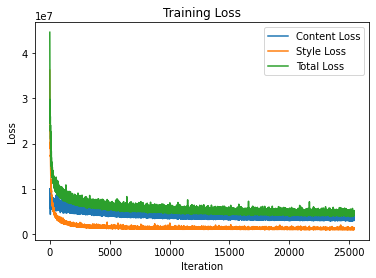

Image Saved!
Image Saved!
Image Saved!
Image Saved!
Image Saved!
[Epoch 1/5] [Batch 0/40670] [Content: 8461623.00 (8461623.00) Style: 39246488.00 (39246488.00) Total: 47708112.00 (47708112.00)]
[Epoch 1/5] [Batch 1000/40670] [Content: 5355449.00 (6664649.30) Style: 2848637.75 (6817591.64) Total: 8204087.00 (13482240.94)]
[Epoch 1/5] [Batch 2000/40670] [Content: 6146132.00 (6298019.63) Style: 1971700.38 (4530690.67) Total: 8117832.50 (10828710.31)]
[Epoch 1/5] [Batch 3000/40670] [Content: 5093133.00 (6058844.30) Style: 1553169.12 (3607417.78) Total: 6646302.00 (9666262.08)]
[Epoch 1/5] [Batch 4000/40670] [Content: 5847671.50 (5859061.83) Style: 1553931.38 (3097871.26) Total: 7401603.00 (8956933.09)]
[Epoch 1/5] [Batch 5000/40670] [Content: 5308202.00 (5689799.50) Style: 1569104.75 (2769662.19) Total: 6877307.00 (8459461.70)]
[Epoch 2/5] [Batch 0/40670] [Content: 4647085.00 (4647085.00) Style: 1370275.25 (1370275.25) Total: 6017360.00 (6017360.00)]
[Epoch 2/5] [Batch 1000/40670] [Content

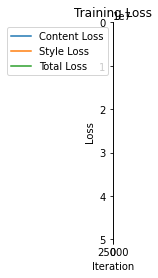

Image Saved!
Image Saved!
Image Saved!
Image Saved!
Image Saved!
[Epoch 1/5] [Batch 0/40670] [Content: 8655293.00 (8655293.00) Style: 20241372.00 (20241372.00) Total: 28896664.00 (28896664.00)]


In [ ]:
import gc 

styles = os.listdir("styles")

# del DATASET
torch.cuda.empty_cache()
gc.collect()

for style in styles:
    if "ipynb_checkpoints" in style:
      continue
    if "DATASET" in globals():
       del DATASET
    torch.cuda.empty_cache()
    gc.collect()
    style_path = f"./styles/{style}"
    style_name = style[:style.rfind(".")]
    fast_trainer(
      style_image=style_path,
      style_name=style_name,
      dataset_path='./dataset/',
      epochs=5,
      image_size=364,
      style_size=448,
      batch_size=8,
      lr=1e-5,
      # checkpoint_model = None,
      checkpoint_interval=200,
      sample_interval=200,
      lambda_style=10e10,
      lambda_content=10e5,
    )
    torch.cuda.empty_cache()
    gc.collect()
    DATASET = datasets.ImageFolder("./dataset")
    np.random.seed(120)
    for random_image_index in np.random.randint(0, len(DATASET) - 1, size=5):
        DATASET[random_image_index][0].save(f"image_{random_image_index}.jpeg", "JPEG")
        test_image(
            image_path=f"image_{random_image_index}.jpeg",
            checkpoint_model=f"{GDRIVE_PATH}/checkpoints/{style_name}_last_checkpoint.pth",
            save_path ='./',
            save_name=f"image_{random_image_index}_{style_name}",
        )

van_gog.jpg


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

[Epoch 1/5] [Batch 0/40670] [Content: 8365600.50 (8365600.50) Style: 31783108.00 (31783108.00) Total: 40148708.00 (40148708.00)]
[Epoch 1/5] [Batch 1000/40670] [Content: 6796485.50 (7873030.63) Style: 2166472.25 (5436945.76) Total: 8962958.00 (13309976.40)]
[Epoch 1/5] [Batch 2000/40670] [Content: 7319957.50 (7529025.27) Style: 1665617.12 (3631146.19) Total: 8985575.00 (11160171.47)]
[Epoch 1/5] [Batch 3000/40670] [Content: 6095242.50 (7239628.24) Style: 1399454.12 (2927611.20) Total: 7494696.50 (10167239.44)]
[Epoch 1/5] [Batch 4000/40670] [Content: 6879550.50 (6998115.96) Style: 1361653.00 (2547647.77) Total: 8241203.50 (9545763.73)]
[Epoch 1/5] [Batch 5000/40670] [Content: 6173206.00 (6799285.49) Style: 1340835.50 (2306017.79) Total: 7514041.50 (9105303.28)]
[Epoch 2/5] [Batch 0/40670] [Content: 5696656.50 (5696656.50) Style: 1165794.25 (1165794.25) Total: 6862451.00 (6862451.00)]
[Epoch 2/5] [Batch 1000/40670] [Content: 5287547.50 (5783955.91) Style: 1399782.88 (1283389.44) Total: 

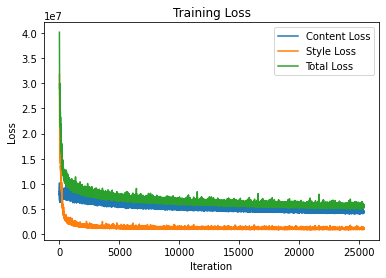

Image Saved!
Image Saved!
Image Saved!
Image Saved!
Image Saved!
mone2_.jpg
[Epoch 1/5] [Batch 0/40670] [Content: 8461623.00 (8461623.00) Style: 21212986.00 (21212986.00) Total: 29674608.00 (29674608.00)]
[Epoch 1/5] [Batch 1000/40670] [Content: 4238873.50 (5822777.60) Style: 1078703.38 (1634592.66) Total: 5317577.00 (7457370.26)]
[Epoch 1/5] [Batch 2000/40670] [Content: 5035857.50 (5305156.36) Style: 921536.50 (1287967.56) Total: 5957394.00 (6593123.92)]
[Epoch 1/5] [Batch 3000/40670] [Content: 3908738.75 (4988240.88) Style: 825598.81 (1157451.05) Total: 4734337.50 (6145691.94)]
[Epoch 1/5] [Batch 4000/40670] [Content: 4426879.00 (4759526.60) Style: 1006297.38 (1087095.05) Total: 5433176.50 (5846621.65)]
[Epoch 1/5] [Batch 5000/40670] [Content: 4223675.50 (4585491.17) Style: 781202.06 (1040170.04) Total: 5004877.50 (5625661.20)]
[Epoch 2/5] [Batch 0/40670] [Content: 3425870.50 (3425870.50) Style: 746518.31 (746518.31) Total: 4172388.75 (4172388.75)]
[Epoch 2/5] [Batch 1000/40670] [Con

In [ ]:
import gc 

styles = os.listdir("styles")

# del DATASET
torch.cuda.empty_cache()
gc.collect()

for style in styles:
    if "ipynb_checkpoints" in style:
      continue
    if "DATASET" in globals():
       del DATASET
    print(style)
    torch.cuda.empty_cache()
    gc.collect()
    style_path = f"./styles/{style}"
    style_name = style[:style.rfind(".")]
    fast_trainer(
      style_image=style_path,
      style_name=style_name,
      dataset_path='./dataset/',
      epochs=5,
      image_size=364,
      style_size=448,
      batch_size=8,
      lr=1e-5,
      # checkpoint_model = None,
      checkpoint_interval=200,
      sample_interval=200,
      lambda_style=10e10,
      lambda_content=10e5,
    )
    torch.cuda.empty_cache()
    gc.collect()
    DATASET = datasets.ImageFolder("./dataset")
    np.random.seed(120)
    for random_image_index in np.random.randint(0, len(DATASET) - 1, size=5):
        DATASET[random_image_index][0].save(f"image_{random_image_index}.jpeg", "JPEG")
        test_image(
            image_path=f"image_{random_image_index}.jpeg",
            checkpoint_model=f"{GDRIVE_PATH}/checkpoints/{style_name}_last_checkpoint.pth",
            save_path ='./',
            save_name=f"image_{random_image_index}_{style_name}",
        )

kandinsky.jpg


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

[Epoch 1/5] [Batch 0/40670] [Content: 8365600.50 (8365600.50) Style: 94793744.00 (94793744.00) Total: 103159344.00 (103159344.00)]
[Epoch 1/5] [Batch 1000/40670] [Content: 12369287.00 (13136710.23) Style: 8940502.00 (17434329.29) Total: 21309788.00 (30571039.51)]
[Epoch 1/5] [Batch 2000/40670] [Content: 13003230.00 (13068608.13) Style: 4867095.00 (11679149.32) Total: 17870324.00 (24747757.43)]
[Epoch 1/5] [Batch 3000/40670] [Content: 11847073.00 (12835488.07) Style: 3784411.50 (9217045.26) Total: 15631484.00 (22052533.31)]
[Epoch 1/5] [Batch 4000/40670] [Content: 11853874.00 (12581847.10) Style: 3326327.00 (7820644.59) Total: 15180201.00 (20402491.68)]
[Epoch 1/5] [Batch 5000/40670] [Content: 11703658.00 (12345115.90) Style: 3188215.00 (6912350.71) Total: 14891873.00 (19257466.60)]
[Epoch 2/5] [Batch 0/40670] [Content: 11008774.00 (11008774.00) Style: 2949730.00 (2949730.00) Total: 13958504.00 (13958504.00)]
[Epoch 2/5] [Batch 1000/40670] [Content: 10806821.00 (11040276.44) Style: 3322

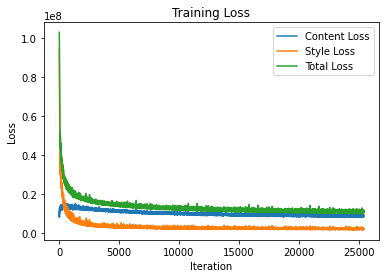

Image Saved!
Image Saved!
Image Saved!
Image Saved!
Image Saved!
mone2_.jpg
[Epoch 1/5] [Batch 0/40670] [Content: 8461623.00 (8461623.00) Style: 21212986.00 (21212986.00) Total: 29674608.00 (29674608.00)]
[Epoch 1/5] [Batch 1000/40670] [Content: 4238966.50 (5822638.09) Style: 1078618.38 (1634570.28) Total: 5317585.00 (7457208.38)]
[Epoch 1/5] [Batch 2000/40670] [Content: 5036179.50 (5305128.08) Style: 921645.81 (1287944.59) Total: 5957825.50 (6593072.68)]
[Epoch 1/5] [Batch 3000/40670] [Content: 3908787.75 (4988232.13) Style: 825999.50 (1157453.24) Total: 4734787.00 (6145685.38)]
[Epoch 1/5] [Batch 4000/40670] [Content: 4426576.00 (4759527.81) Style: 1006388.06 (1087132.06) Total: 5432964.00 (5846659.87)]
[Epoch 1/5] [Batch 5000/40670] [Content: 4224083.50 (4585508.31) Style: 781522.69 (1040242.37) Total: 5005606.00 (5625750.68)]
[Epoch 2/5] [Batch 0/40670] [Content: 3426053.00 (3426053.00) Style: 746691.75 (746691.75) Total: 4172744.75 (4172744.75)]
[Epoch 2/5] [Batch 1000/40670] [Con

In [ ]:
import gc 

styles = os.listdir("styles")

# del DATASET
torch.cuda.empty_cache()
gc.collect()

for style in styles:
    if "ipynb_checkpoints" in style:
      continue
    if "DATASET" in globals():
       del DATASET
    print(style)
    torch.cuda.empty_cache()
    gc.collect()
    style_path = f"./styles/{style}"
    style_name = style[:style.rfind(".")]
    fast_trainer(
      style_image=style_path,
      style_name=style_name,
      dataset_path='./dataset/',
      epochs=5,
      image_size=364,
      style_size=448,
      batch_size=8,
      lr=1e-5,
      # checkpoint_model = None,
      checkpoint_interval=200,
      sample_interval=200,
      lambda_style=10e10,
      lambda_content=10e5,
    )
    torch.cuda.empty_cache()
    gc.collect()
    DATASET = datasets.ImageFolder("./dataset")
    np.random.seed(120)
    for random_image_index in np.random.randint(0, len(DATASET) - 1, size=5):
        DATASET[random_image_index][0].save(f"image_{random_image_index}.jpeg", "JPEG")
        test_image(
            image_path=f"image_{random_image_index}.jpeg",
            checkpoint_model=f"{GDRIVE_PATH}/checkpoints/{style_name}_last_checkpoint.pth",
            save_path ='./',
            save_name=f"image_{random_image_index}_{style_name}",
        )

[Epoch 1/3] [Batch 0/40670] [Content: 9564775.00 (9564775.00) Style: 45448732.00 (45448732.00) Total: 55013508.00 (55013508.00)]
[Epoch 1/3] [Batch 1000/40670] [Content: 5553810.00 (7165463.60) Style: 3390401.25 (8241913.95) Total: 8944211.00 (15407377.54)]
[Epoch 1/3] [Batch 2000/40670] [Content: 6694414.50 (6748473.38) Style: 2169394.75 (5424074.40) Total: 8863809.00 (12172547.78)]
[Epoch 1/3] [Batch 3000/40670] [Content: 5317053.00 (6480617.85) Style: 1851247.38 (4286971.23) Total: 7168300.50 (10767589.08)]
[Epoch 1/3] [Batch 4000/40670] [Content: 6083544.50 (6263846.54) Style: 1720233.88 (3664950.50) Total: 7803778.50 (9928797.04)]
[Epoch 1/3] [Batch 5000/40670] [Content: 5565868.50 (6081993.21) Style: 1653705.25 (3268143.98) Total: 7219574.00 (9350137.18)]
[Epoch 2/3] [Batch 0/40670] [Content: 4953597.00 (4953597.00) Style: 1543691.88 (1543691.88) Total: 6497289.00 (6497289.00)]
[Epoch 2/3] [Batch 1000/40670] [Content: 4412583.00 (5138536.45) Style: 1551417.50 (1592530.19) Total: 

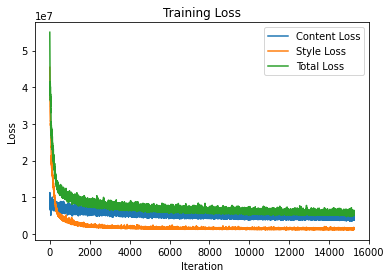

Image Saved!
Image Saved!
Image Saved!
Image Saved!
Image Saved!


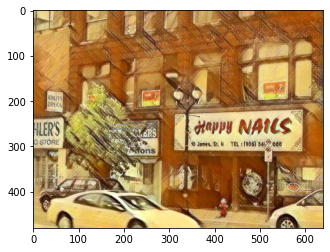

In [ ]:
import gc 

styles = ["picasso_selfportrait.jpg"]

# del DATASET
torch.cuda.empty_cache()
gc.collect()

for style in styles:
    if "ipynb_checkpoints" in style:
      continue
    if "DATASET" in globals():
       del DATASET
    torch.cuda.empty_cache()
    gc.collect()
    style_path = f"./styles/{style}"
    style_name = style[:style.rfind(".")]
    fast_trainer(
      style_image=style_path,
      style_name=style_name,
      dataset_path='./dataset/',
      epochs=3,
      image_size=256,
      style_size=448,
      batch_size=8,
      lr=1e-5,
      # checkpoint_model = None,
      checkpoint_interval=200,
      sample_interval=200,
      lambda_style=10e10,
      lambda_content=10e5,
    )
    torch.cuda.empty_cache()
    gc.collect()
    DATASET = datasets.ImageFolder("./dataset")
    np.random.seed(120)
    for random_image_index in np.random.randint(0, len(DATASET) - 1, size=5):
        DATASET[random_image_index][0].save(f"image_{random_image_index}.jpeg", "JPEG")
        test_image(
            image_path=f"image_{random_image_index}.jpeg",
            checkpoint_model=f"{GDRIVE_PATH}/checkpoints/{style_name}_last_checkpoint.pth",
            save_path ='./',
            save_name=f"image_{random_image_index}_{style_name}",
        )

In [ ]:
import gc 

styles = ["van_gog.jpg", "monet.jpg", "mone2.jpg", "kandinsky.jpg", "munk.jpeg"]

# del DATASET
torch.cuda.empty_cache()
gc.collect()

for style in styles:
    if "ipynb_checkpoints" in style:
      continue
    if "DATASET" in globals():
       del DATASET
    torch.cuda.empty_cache()
    gc.collect()
    style_path = f"./styles/{style}"
    style_name = style[:style.rfind(".")]
    fast_trainer(
      style_image=style_path,
      style_name=style_name,
      dataset_path='./dataset/',
      epochs=5,
      image_size=256,
      style_size=448,
      batch_size=8,
      lr=1e-5,
      # checkpoint_model = None,
      checkpoint_interval=200,
      sample_interval=200,
      lambda_style=10e10,
      lambda_content=10e5,
    )
    torch.cuda.empty_cache()
    gc.collect()
    DATASET = datasets.ImageFolder("./dataset")
    np.random.seed(120)
    for random_image_index in np.random.randint(0, len(DATASET) - 1, size=5):
        DATASET[random_image_index][0].save(f"image_{random_image_index}.jpeg", "JPEG")
        test_image(
            image_path=f"image_{random_image_index}.jpeg",
            checkpoint_model=f"{GDRIVE_PATH}/checkpoints/{style_name}_last_checkpoint.pth",
            save_path ='./',
            save_name=f"image_{random_image_index}_{style_name}",
        )

In [ ]:
exit(0)

In [ ]:
torch.cuda.empty_cache()
gc.collect()

2548

In [ ]:
# style_name = "munk"
# for random_image_index in np.random.randint(0, len(DATASET) - 1, size=5):
#       DATASET[random_image_index][0].save(f"image_{random_image_index}.jpeg", "JPEG")
#       test_image(
#           image_path=f"image_{random_image_index}.jpeg",
#           checkpoint_model=f"{GDRIVE_PATH}/checkpoints/{style_name}_last_checkpoint.pth",
#           save_path=GDRIVE_PATH,
#           save_name=f"image_{random_image_index}_{style_name}",
#       )
#       plt.show()

In [ ]:
exit(0)